In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/obesity-dataset/train.csv
/kaggle/input/obesity-dataset/test.csv


In [2]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv("/kaggle/input/obesity-dataset/train.csv")
test = pd.read_csv("/kaggle/input/obesity-dataset/test.csv")

In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (15533, 18)
Test shape: (5225, 17)


In [5]:
print("\n--- Basic Information ---")
print(train.info())


--- Basic Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  float64
 12  SCC  

In [6]:
print("\n--- Summary Statistics (Numerical Columns) ---")
print(train.describe().T)


--- Summary Statistics (Numerical Columns) ---
          count         mean          std    min          25%          50%  \
id      15533.0  7766.000000  4484.135201   0.00  3883.000000  7766.000000   
Age     15533.0    23.816308     5.663167  14.00    20.000000    22.771612   
Height  15533.0     1.699918     0.087670   1.45     1.630927     1.700000   
Weight  15533.0    87.785225    26.369144  39.00    66.000000    84.000000   
FCVC    15533.0     2.442917     0.530895   1.00     2.000000     2.342220   
NCP     15533.0     2.760425     0.706463   1.00     3.000000     3.000000   
CH2O    15533.0     2.027626     0.607733   1.00     1.796257     2.000000   
FAF     15533.0     0.976968     0.836841   0.00     0.007050     1.000000   
TUE     15533.0     0.613813     0.602223   0.00     0.000000     0.566353   

                 75%           max  
id      11649.000000  15532.000000  
Age        26.000000     61.000000  
Height      1.762921      1.975663  
Weight    111.600553   


--- Missing Values ---
Series([], dtype: int64)


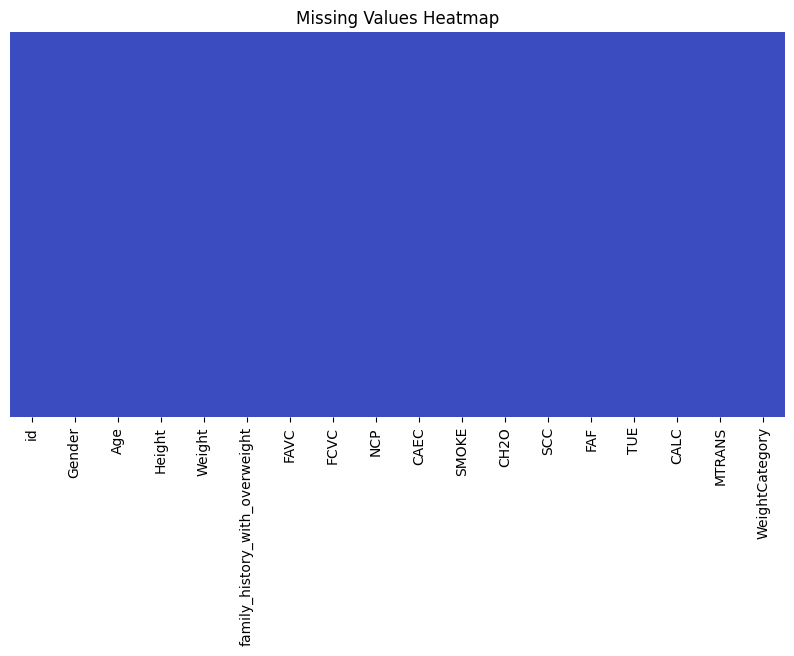

In [7]:
print("\n--- Missing Values ---")
print(train.isnull().sum()[train.isnull().sum() > 0])
plt.figure(figsize=(10,5))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='coolwarm')
plt.title("Missing Values Heatmap")
plt.show()

In [8]:
print("\n--- Target Distribution ---")
print("\n--- No of classes---\n", train["WeightCategory"].nunique())
print("\n--- Name of classes---\n", train["WeightCategory"].unique())
print("\n--- Count of each classes---\n",train["WeightCategory"].value_counts())


--- Target Distribution ---

--- No of classes---
 7

--- Name of classes---
 ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']

--- Count of each classes---
 WeightCategory
Obesity_Type_III       2983
Obesity_Type_II        2403
Normal_Weight          2345
Obesity_Type_I         2207
Overweight_Level_II    1881
Insufficient_Weight    1870
Overweight_Level_I     1844
Name: count, dtype: int64


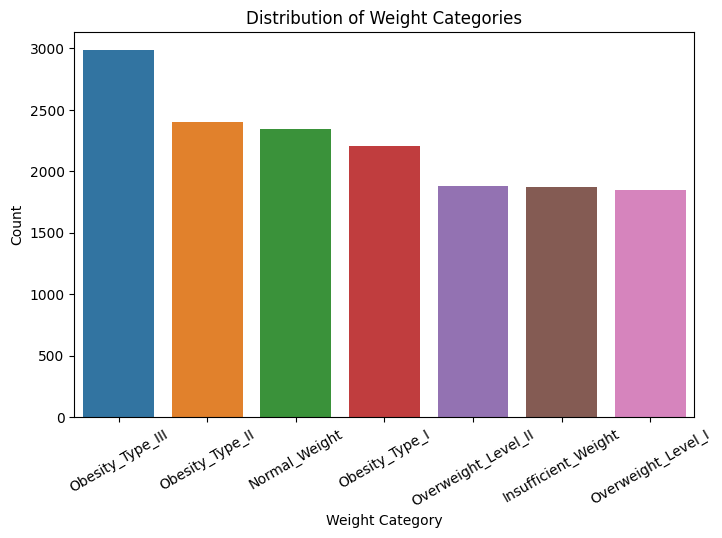

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(data=train, x="WeightCategory", order=train["WeightCategory"].value_counts().index)
plt.title("Distribution of Weight Categories")
plt.xlabel("Weight Category")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


Numeric Columns (8): ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


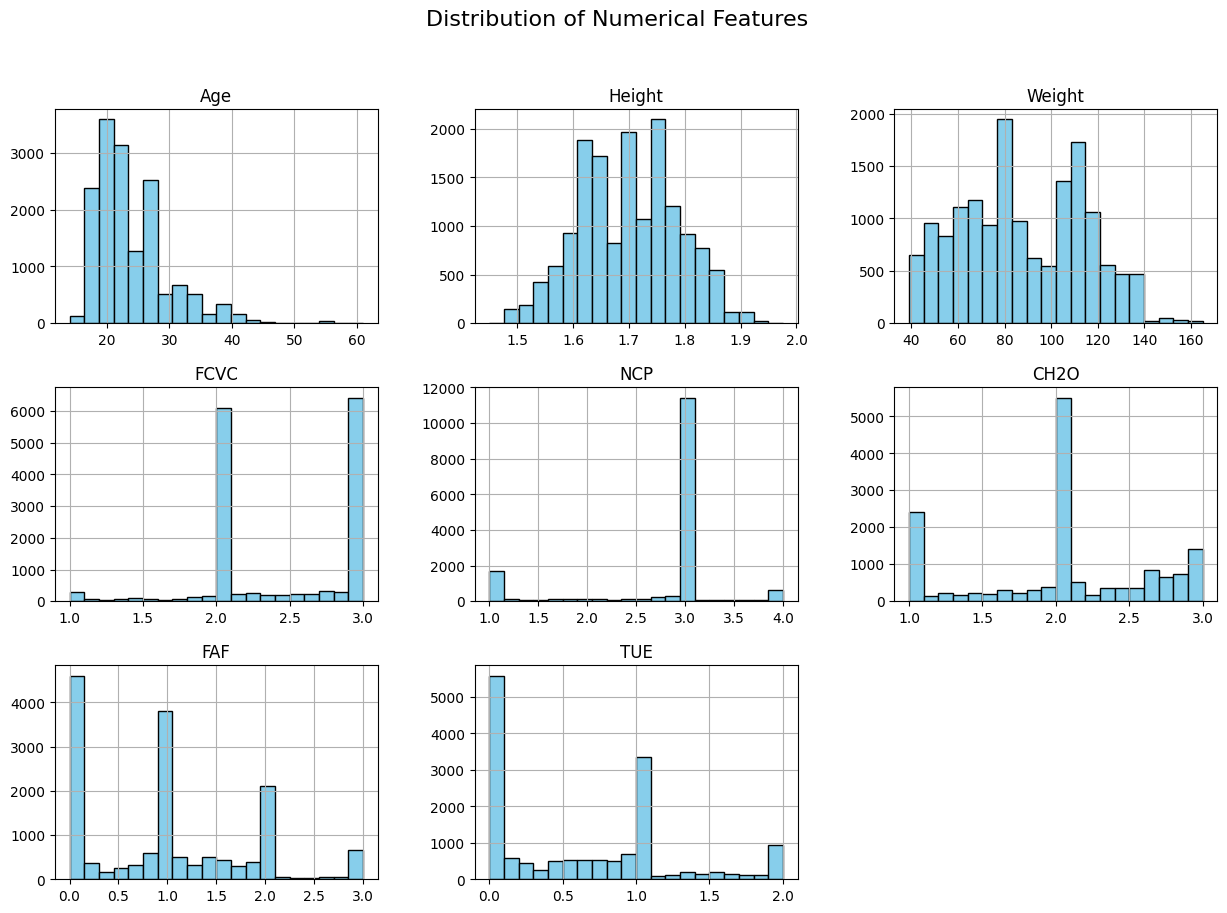

In [10]:
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if "id" in num_cols:
    num_cols.remove("id")

print(f"\nNumeric Columns ({len(num_cols)}):", num_cols)

train[num_cols].hist(figsize=(15,10), bins=20, color="skyblue", edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

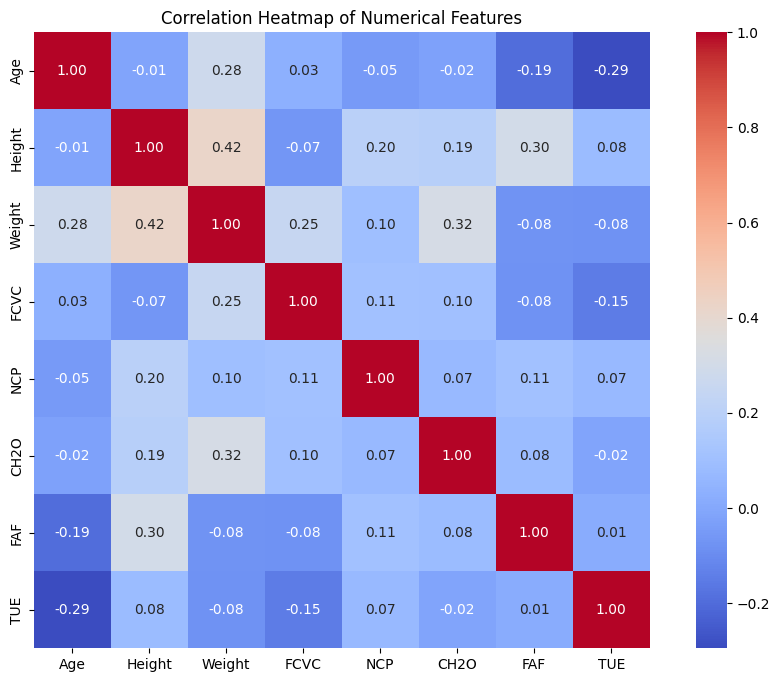

In [11]:
plt.figure(figsize=(12,8))
corr = train[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


Categorical Columns (9): ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'WeightCategory']


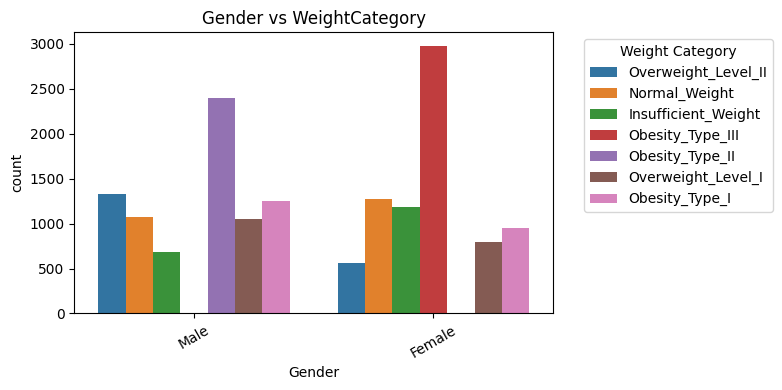

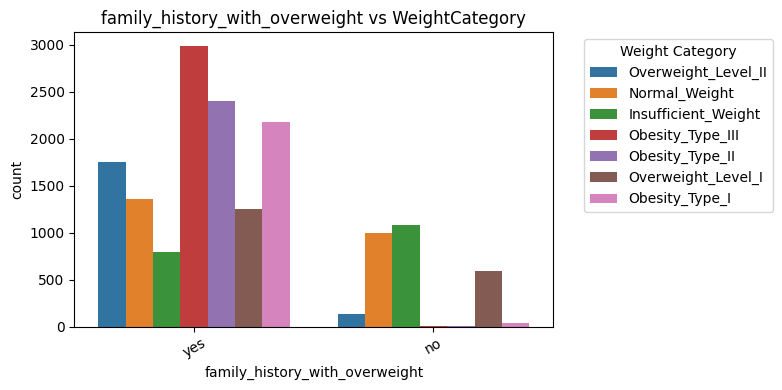

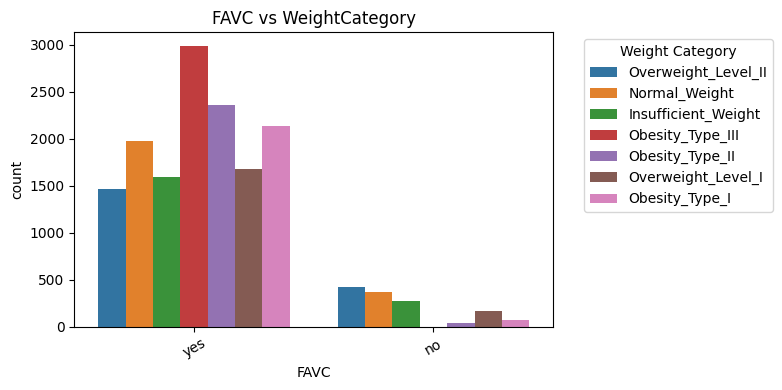

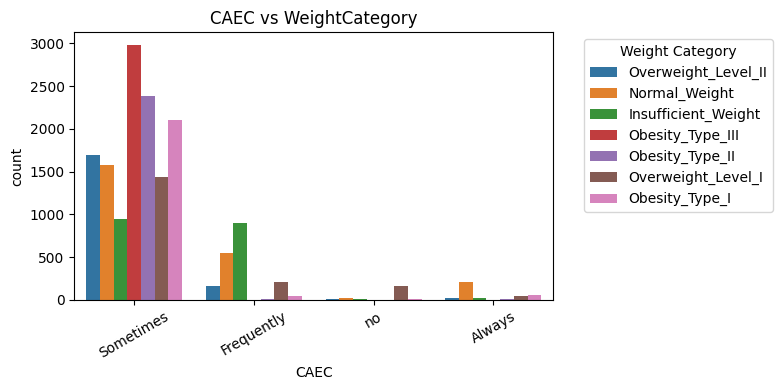

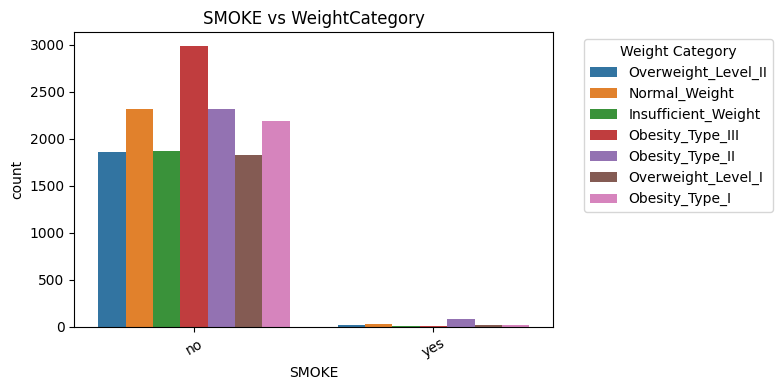

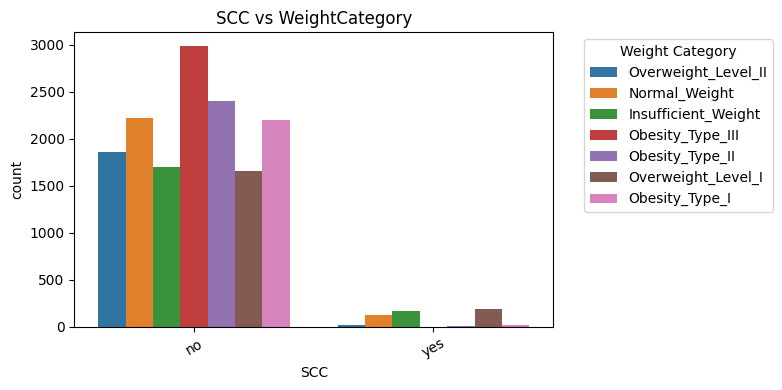

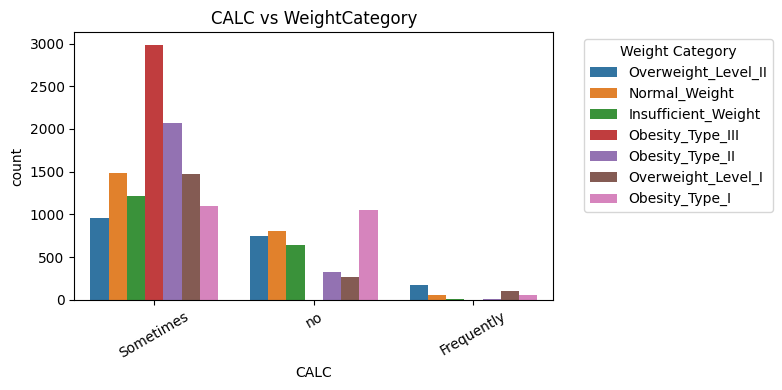

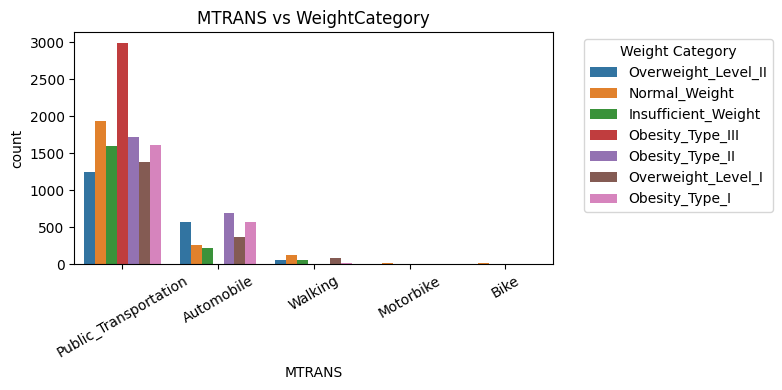

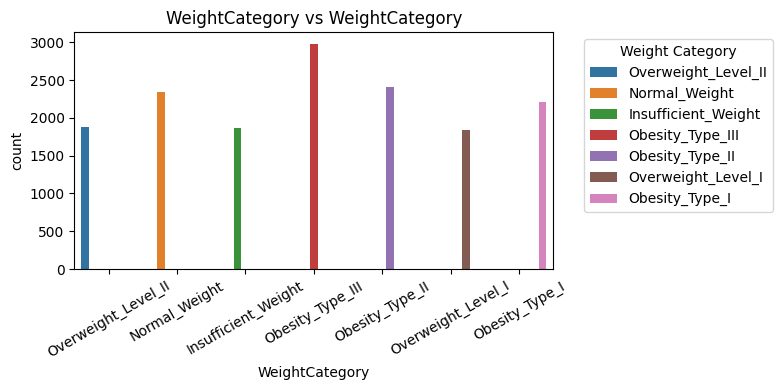

In [12]:
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()
print(f"\nCategorical Columns ({len(cat_cols)}):", cat_cols)

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=train, x=col, hue="WeightCategory")
    plt.title(f"{col} vs WeightCategory")
    plt.xticks(rotation=30)
    plt.legend(title="Weight Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

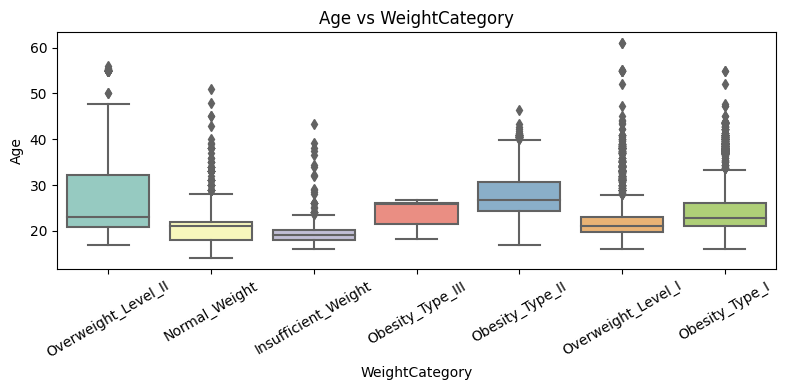

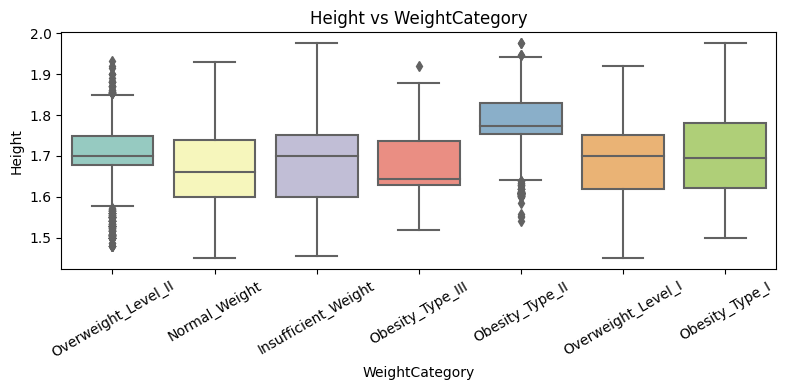

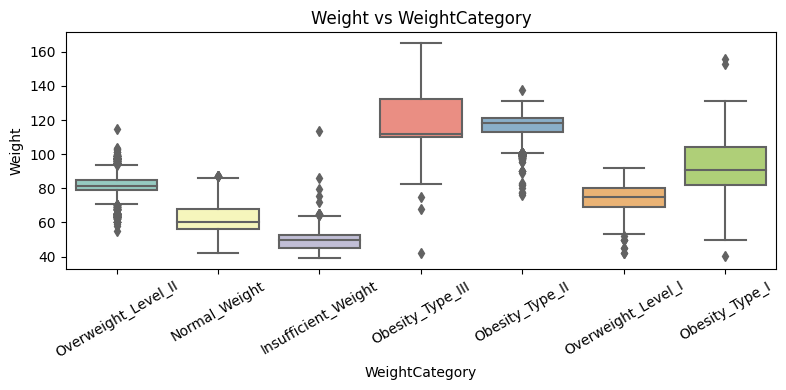

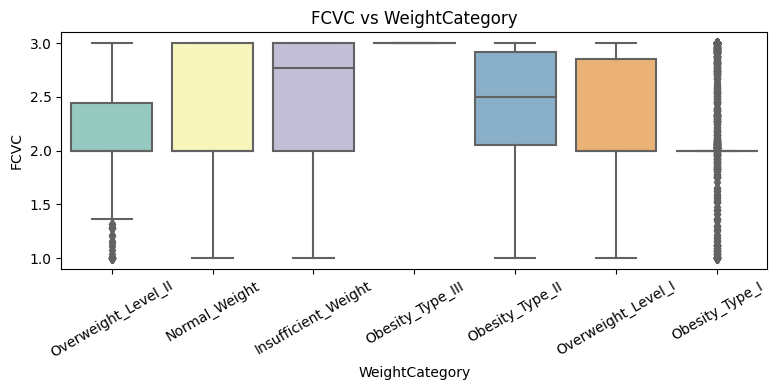

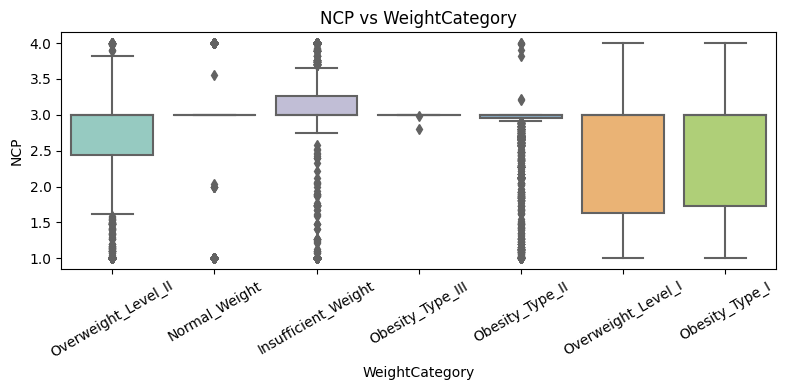

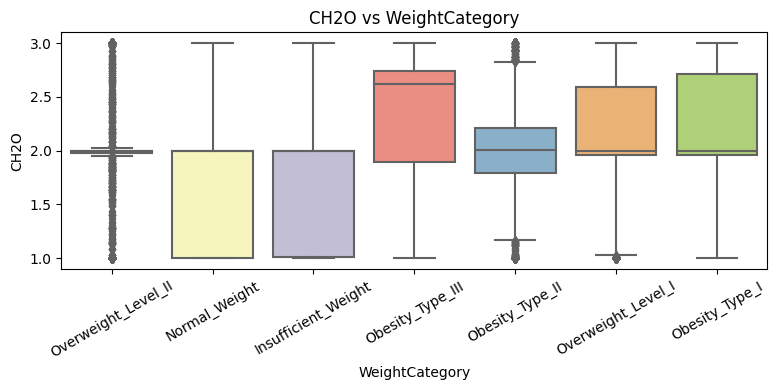

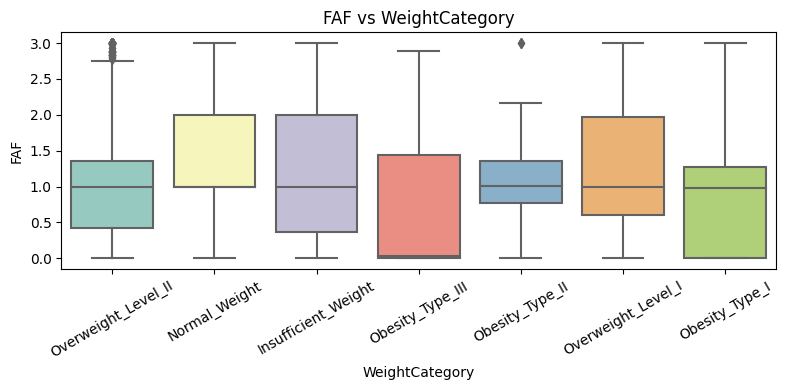

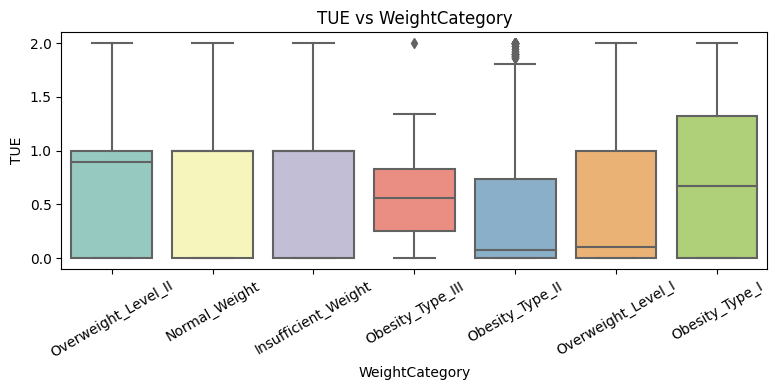

In [13]:
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=train, x="WeightCategory", y=col, palette="Set3")
    plt.title(f"{col} vs WeightCategory")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [14]:
target_map = {cat:i for i, cat in enumerate(train["WeightCategory"].unique())}
train["TargetNum"] = train["WeightCategory"].map(target_map)

print("\n--- Feature Correlation with Target ---")
print(train[num_cols + ["TargetNum"]].corr()["TargetNum"].sort_values(ascending=False))


--- Feature Correlation with Target ---
TargetNum    1.000000
Weight       0.347940
Age          0.150003
CH2O         0.131557
Height       0.095460
TUE         -0.045575
FAF         -0.061484
FCVC        -0.087592
NCP         -0.127331
Name: TargetNum, dtype: float64


In [5]:
X = train.drop(columns=["WeightCategory", "id"])
y = train["WeightCategory"]

print("Features shape:", X.shape, "Target shape:", y.shape)

Features shape: (15533, 16) Target shape: (15533,)


In [6]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=False)
test_encoded = pd.get_dummies(test.drop(columns=["id"], errors="ignore"), columns=cat_cols, drop_first=False)

test_encoded = test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_np = X_encoded.values
y_np = y_encoded
test_np = test_encoded.values

print("Train shape:", X_encoded.shape, "Test shape:", test_encoded.shape)

Train shape: (15533, 30) Test shape: (5225, 30)


In [7]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 900),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.0015, 0.08, log=True),
        "subsample": trial.suggest_float("subsample", 0.55, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.55, 0.95),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "use_label_encoder": False,
        "predictor" : "cpu_predictor",
        "n_jobs": -1,
        "random_state": 42
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for tr_idx, va_idx in cv.split(X_np, y_np):
        X_tr, X_va = X_np[tr_idx], X_np[va_idx]
        y_tr, y_va = y_np[tr_idx], y_np[va_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            early_stopping_rounds=50,
            verbose=False
        )
        preds = model.predict(X_va)
        scores.append(accuracy_score(y_va, preds))

    return float(np.mean(scores))


In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=True)

print("Best CV score:", study.best_value)
print("Best params:", study.best_params)


[I 2025-10-25 12:01:46,738] A new study created in memory with name: no-name-9986236f-de5f-4a36-a35a-21fe0ed61120


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-10-25 12:01:53,229] Trial 0 finished with value: 0.8995042845195864 and parameters: {'n_estimators': 204, 'max_depth': 8, 'learning_rate': 0.03588830966407352, 'subsample': 0.7521535494742736, 'colsample_bytree': 0.6500278936570777, 'min_child_weight': 10, 'gamma': 0.20030238864075145, 'reg_lambda': 4.482964580117082, 'reg_alpha': 4.6224502704834425}. Best is trial 0 with value: 0.8995042845195864.
[I 2025-10-25 12:02:02,815] Trial 1 finished with value: 0.9043970768389834 and parameters: {'n_estimators': 279, 'max_depth': 9, 'learning_rate': 0.04146878222647206, 'subsample': 0.6612687769021582, 'colsample_bytree': 0.9076353093576304, 'min_child_weight': 1, 'gamma': 0.3279993222242421, 'reg_lambda': 2.410352274998096, 'reg_alpha': 3.4321524509226693}. Best is trial 1 with value: 0.9043970768389834.
[I 2025-10-25 12:02:16,006] Trial 2 finished with value: 0.8606837086489376 and parameters: {'n_estimators': 561, 'max_depth': 4, 'learning_rate': 0.0015107930298698135, 'subsample':

In [9]:
K = 5  
top_trials = sorted([t for t in study.trials if t.value is not None], key=lambda t: t.value, reverse=True)[:K]

print(f"\nTop {K} Optuna Trials to be used in ensemble:")
for i, t in enumerate(top_trials, 1):
    print(f"\nModel {i}:")
    print(f"  CV Score: {t.value:.6f}")
    print(f"  Parameters:")
    for param_name, param_value in t.params.items():
        print(f"    {param_name}: {param_value}")


Top 5 Optuna Trials to be used in ensemble:

Model 1:
  CV Score: 0.907809
  Parameters:
    n_estimators: 864
    max_depth: 7
    learning_rate: 0.016197843097304033
    subsample: 0.8795243148555005
    colsample_bytree: 0.5662582540149954
    min_child_weight: 4
    gamma: 0.40338794480209744
    reg_lambda: 1.809857523945504
    reg_alpha: 1.6319609599301632

Model 2:
  CV Score: 0.907552
  Parameters:
    n_estimators: 790
    max_depth: 7
    learning_rate: 0.016688521994264915
    subsample: 0.8411853336412763
    colsample_bytree: 0.5504128653596865
    min_child_weight: 4
    gamma: 0.47895310327319995
    reg_lambda: 1.8881546082687573
    reg_alpha: 1.3696019494597906

Model 3:
  CV Score: 0.907487
  Parameters:
    n_estimators: 887
    max_depth: 7
    learning_rate: 0.02025152143372302
    subsample: 0.8583918480897677
    colsample_bytree: 0.5594227548629741
    min_child_weight: 4
    gamma: 0.5001672899503586
    reg_lambda: 1.570831623743398
    reg_alpha: 1.7147482

In [10]:
K = 5  
X_tr_full, X_hold, y_tr_full, y_hold = train_test_split(X_np, y_np, test_size=0.15, random_state=99, stratify=y_np)

top_trials = sorted([t for t in study.trials if t.value is not None], key=lambda t: t.value, reverse=True)[:K]
print("Using top", len(top_trials), "trials for ensemble")

models = []
for i, t in enumerate(top_trials):
    params = t.params.copy()
    params.update({
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
        "tree_method": "hist",
        "n_jobs": -1,
        "random_state": 42 + i  
    })

    m = XGBClassifier(**params)
    m.fit(X_tr_full, y_tr_full, eval_set=[(X_hold, y_hold)], early_stopping_rounds=50, verbose=False)
    models.append(m)
    print(f" Trained ensemble member {i+1} (trial value={t.value:.4f})")

probs = np.mean([m.predict_proba(X_hold) for m in models], axis=0)
ensemble_preds = np.argmax(probs, axis=1)
ensemble_acc = accuracy_score(y_hold, ensemble_preds)
print(f"Ensemble holdout accuracy: {ensemble_acc*100:.4f}%")


Using top 5 trials for ensemble
 Trained ensemble member 1 (trial value=0.9078)
 Trained ensemble member 2 (trial value=0.9076)
 Trained ensemble member 3 (trial value=0.9075)
 Trained ensemble member 4 (trial value=0.9075)
 Trained ensemble member 5 (trial value=0.9074)
Ensemble holdout accuracy: 90.2575%


In [11]:
print("Retraining ensemble members on full training data and predicting test...")

final_models = []
for i, t in enumerate(top_trials):
    params = t.params.copy()
    params.update({
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
        "tree_method": "hist",
        "n_jobs": -1,
        "random_state": 42 + i
    })
    m = XGBClassifier(**params)
    class_counts = np.bincount(y_np)
    class_weights = {i: (len(y_np) / (len(class_counts) * c)) for i, c in enumerate(class_counts)}
    sample_weight = np.array([class_weights[label] for label in y_np])
    
    m.fit(X_np, y_np, sample_weight=sample_weight, verbose=False)
    final_models.append(m)
    print(f" Final model {i+1} trained.")

test_probas = np.mean([m.predict_proba(test_np) for m in final_models], axis=0)
test_preds = np.argmax(test_probas, axis=1)
test_labels = le.inverse_transform(test_preds)


Retraining ensemble members on full training data and predicting test...
 Final model 1 trained.
 Final model 2 trained.
 Final model 3 trained.
 Final model 4 trained.
 Final model 5 trained.


In [13]:
submission = pd.DataFrame({"id": test["id"], "WeightCategory": test_labels})
submission.to_csv("MT2025055_MT2025029_updated_parameters_150_trial.csv", index=False)
print("Saved submission_optuna_ensemble.csv. Ensemble test distribution:")
print(submission["WeightCategory"].value_counts(normalize=True).round(3) * 100)


Saved submission_optuna_ensemble.csv. Ensemble test distribution:
WeightCategory
Obesity_Type_III       20.3
Obesity_Type_II        16.1
Normal_Weight          14.1
Obesity_Type_I         13.4
Insufficient_Weight    12.9
Overweight_Level_II    12.6
Overweight_Level_I     10.5
Name: proportion, dtype: float64
